In [19]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Embedding, Concatenate,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam

In [20]:
# Load data
events = pd.read_csv("customer_events.csv")
profiles = pd.read_csv("customer_profiles.csv")

# Merge
data = events.merge(profiles, on="customer_id", how="left")

# Encode categorical columns
encoders = {}
for col in ['event_type', 'action_taken', 'channel', 'gender', 'location', 'product_owned']:
    le = LabelEncoder()
    data[col + '_id'] = le.fit_transform(data[col])
    encoders[col] = le

In [21]:
events.head()

,customer_id,timestamp,event_type,amount,action_taken,channel,responded,converted,fatigue_count,gap_days,reward
0,C000,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
1,C000,2023-06-06 00:00:00,purchase,1067,SMS Offer,SMS,1,0,0,5,2.0
2,C000,2023-06-11 00:00:00,click,0,SMS Offer,SMS,0,1,1,5,19.5
3,C001,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
4,C001,2023-06-04 00:00:00,visit,0,Call,Call,0,0,0,3,-1.0


In [22]:
events["action_taken"].unique()

array(['Email Promo', 'SMS Offer', 'Call', 'No Action'], dtype=object)

In [3]:
# Instead of only feeding event IDs like:

# [Email Promo, SMS Offer, Call]


# we’ll also feed parallel response data:

# [0, 1, 0]  → whether the customer responded to each event


# Optionally, we can extend this later to:

# [converted flags] too.


# This gives the Transformer richer temporal context — e.g.

# “Last time SMS → responded → conversion likely if followed by Call.”

In [4]:
# We’ll now maintain three histories inside the environment:

# event_history: campaign names (for event embedding)

# response_history: binary 0/1 sequence

# conversion_history: binary 0/1 sequence

In [2]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Embedding, Concatenate,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [23]:
# | Variable             | Description                                                         | Used for                                             |
# | -------------------- | ------------------------------------------------------------------- | ---------------------------------------------------- |
# | `event_history`      | Stores which campaigns were sent (e.g., `["Email", "SMS", "Call"]`) | fed into the Transformer as `event_seq`              |
# | `response_history`   | Stores whether the user responded (0/1) after each event            | fed as `resp_seq`                                    |
# | `conversion_history` | Stores whether the user converted (0/1) after each event            | fed as `conv_seq` and determines episode termination |


In [24]:
events.head()

,customer_id,timestamp,event_type,amount,action_taken,channel,responded,converted,fatigue_count,gap_days,reward
0,C000,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
1,C000,2023-06-06 00:00:00,purchase,1067,SMS Offer,SMS,1,0,0,5,2.0
2,C000,2023-06-11 00:00:00,click,0,SMS Offer,SMS,0,1,1,5,19.5
3,C001,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
4,C001,2023-06-04 00:00:00,visit,0,Call,Call,0,0,0,3,-1.0


In [3]:
class MarketingEnv:
    def __init__(self, campaigns, base_conversion, fatigue_penalty=0.03, max_seq_len=10):
        self.campaigns = campaigns
        self.base_conversion = base_conversion
        self.fatigue_penalty = fatigue_penalty
        self.max_seq_len = max_seq_len
        self.campaign_to_id = {c: i for i, c in enumerate(self.campaigns)}
        self.reset()

    def reset(self):
        self.event_history = []   #channel
        self.response_history = [] #responded
        self.conversion_history = [] #converted
        self.state = {
            "gap_days": 0,
            "fatigue": {a: 0 for a in self.campaigns},
            "responded": 0,
            "converted": 0
        }
        self.response_memory = 0.0 # is never fed directly to the model,, is used only inside the environment,Without it, 
                                    # your environment behaves independently each step — i.e., every campaign is a fresh coin toss.
        self.steps = 0
        return self._get_state_vector()

    def _get_state_vector(self):
        event_ids = [self.campaign_to_id.get(e, 0) for e in self.event_history[-self.max_seq_len:]]
        resp_flags = self.response_history[-self.max_seq_len:]
        conv_flags = self.conversion_history[-self.max_seq_len:]

        event_padded = np.zeros(self.max_seq_len, dtype=np.int32)
        resp_padded = np.zeros(self.max_seq_len, dtype=np.int32)
        conv_padded = np.zeros(self.max_seq_len, dtype=np.int32)

        event_padded[:len(event_ids)] = event_ids
        resp_padded[:len(resp_flags)] = resp_flags
        conv_padded[:len(conv_flags)] = conv_flags

        return (event_padded, resp_padded, conv_padded)

    def step(self, action_name):
        base_prob = self.base_conversion[action_name]
        fatigue_count = self.state["fatigue"][action_name]

        adjusted_rate = base_prob + 0.1 * self.response_memory
        adjusted_rate = max(adjusted_rate - fatigue_count * self.fatigue_penalty, 0.01)

        responded = 1 if random.random() < adjusted_rate + 0.1 else 0
        converted = 1 if random.random() < adjusted_rate else 0
        self.response_memory = self.response_memory * 0.7 + responded * 0.3

        if converted:
            reward = 20.0
        elif responded:
            reward = 2.0
        else:
            reward = -1.0

        self.state["fatigue"][action_name] += 1
        self.state["gap_days"] = random.randint(1, 5)
        self.state["responded"] = responded
        self.state["converted"] = converted
        self.event_history.append(action_name)
        self.response_history.append(responded)
        self.conversion_history.append(converted)
        self.steps += 1

        next_state = self._get_state_vector()
        done = converted or self.steps >= self.max_seq_len
        return next_state, reward, done

In [6]:
# 🧠 3️⃣ Model Update — Add Response & Conversion Channels

# We’ll now feed three sequences into the Transformer:

# Event type embedding

# Response flag embedding

# Conversion flag embedding

# Then we’ll combine them before passing into the Transformer block.

In [4]:
def transformer_block(x, ff_dim, num_heads):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = LayerNormalization()(x + attn_output)
    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    return LayerNormalization()(x + ffn_output)

def build_q_model(max_seq_len, num_event_types, profile_dim, num_actions,
                  embed_dim=64, ff_dim=128, num_heads=4):
    event_input = Input(shape=(max_seq_len,), name="event_input")
    resp_input = Input(shape=(max_seq_len,), name="response_input")
    conv_input = Input(shape=(max_seq_len,), name="conversion_input")
    profile_input = Input(shape=(profile_dim,), name="profile_input")

    event_embed = Embedding(input_dim=num_event_types, output_dim=embed_dim, mask_zero=True)(event_input)
    resp_embed = Embedding(input_dim=2, output_dim=embed_dim, mask_zero=True)(resp_input)
    conv_embed = Embedding(input_dim=2, output_dim=embed_dim, mask_zero=True)(conv_input)

    x = Concatenate(axis=-1)([event_embed, resp_embed, conv_embed])
    x = Dense(embed_dim, activation="relu")(x)
    x = transformer_block(x, ff_dim, num_heads)
    x = GlobalAveragePooling1D()(x)

    p = Dense(embed_dim, activation="relu")(profile_input)
    merged = Concatenate()([x, p])
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.2)(merged)

    q_values = Dense(num_actions, activation="linear")(merged)
    model = Model(inputs=[event_input, resp_input, conv_input, profile_input], outputs=q_values)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

In [5]:
# 🧩 Initialize Environment & Model

In [6]:
campaigns = ["Email Promo", "SMS Offer", "Call", "No Action"]
base_conversion = {"Email Promo": 0.15, "SMS Offer": 0.20, "Call": 0.25, "No Action": 0.0}

max_seq_len = 10
num_event_types = len(campaigns)
profile_dim = 5
num_actions = len(campaigns)

env = MarketingEnv(campaigns, base_conversion, max_seq_len=max_seq_len)
model = build_q_model(max_seq_len, num_event_types, profile_dim, num_actions)
target_model = clone_model(model)
target_model.set_weights(model.get_weights())


In [8]:
# ⚙️ 4️⃣ Training Loop Adjustments

# We now get three arrays per state instead of one:

# (event_seq, resp_seq, conv_seq)

In [10]:
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
episodes = 30
batch_size = 32
replay_buffer = deque(maxlen=2000)

reward_log = []
loss_log = []
epsilon_log = []

for ep in range(episodes):
    profile = np.random.rand(profile_dim).astype(np.float32)
    state = env.reset()
    total_reward = 0
    done = False
    epoch_losses = []

    while not done:
        event_seq, resp_seq, conv_seq = state
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(num_actions)
        else:
            q_vals = model.predict(
                [event_seq[np.newaxis], resp_seq[np.newaxis], conv_seq[np.newaxis], profile[np.newaxis]], verbose=0)
            action_idx = np.argmax(q_vals[0])

        action_name = campaigns[action_idx]
        next_state, reward, done = env.step(action_name)
        next_event_seq, next_resp_seq, next_conv_seq = next_state

        replay_buffer.append((event_seq, resp_seq, conv_seq, action_idx, reward,
                              next_event_seq, next_resp_seq, next_conv_seq, done))
        total_reward += reward
        state = next_state

        if len(replay_buffer) >= batch_size:
            minibatch = random.sample(replay_buffer, batch_size)

            e_mb = np.array([m[0] for m in minibatch])
            r_mb = np.array([m[1] for m in minibatch])
            c_mb = np.array([m[2] for m in minibatch])
            a_mb = np.array([m[3] for m in minibatch])
            rew_mb = np.array([m[4] for m in minibatch])
            ne_mb = np.array([m[5] for m in minibatch])
            nr_mb = np.array([m[6] for m in minibatch])
            nc_mb = np.array([m[7] for m in minibatch])
            d_mb = np.array([m[8] for m in minibatch])

            q_pred = model.predict([e_mb, r_mb, c_mb, np.tile(profile, (batch_size, 1))], verbose=0)
            q_next = target_model.predict([ne_mb, nr_mb, nc_mb, np.tile(profile, (batch_size, 1))], verbose=0)

            for i in range(batch_size):
                target = rew_mb[i] if d_mb[i] else rew_mb[i] + gamma * np.max(q_next[i])
                q_pred[i, a_mb[i]] = target

            # capture batch loss
            loss = model.train_on_batch([e_mb, r_mb, c_mb, np.tile(profile, (batch_size, 1))], q_pred)
            epoch_losses.append(loss)

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    target_model.set_weights(model.get_weights())

    avg_loss = np.mean(epoch_losses) if epoch_losses else 0
    reward_log.append(total_reward)
    loss_log.append(avg_loss)
    epsilon_log.append(epsilon)

    print(f"Episode {ep+1}/{episodes} | Reward: {total_reward:.1f} | Loss: {avg_loss:.4f} | Epsilon: {epsilon:.3f}")

Episode 1/30 | Reward: 20.0 | Loss: 0.0000 | Epsilon: 0.995
Episode 2/30 | Reward: 19.0 | Loss: 0.0000 | Epsilon: 0.990
Episode 3/30 | Reward: 2.0 | Loss: 0.0000 | Epsilon: 0.985
Episode 4/30 | Reward: 19.0 | Loss: 0.0000 | Epsilon: 0.980
Episode 5/30 | Reward: -1.0 | Loss: 7.4371 | Epsilon: 0.975
Episode 6/30 | Reward: 19.0 | Loss: 7.3301 | Epsilon: 0.970
Episode 7/30 | Reward: 20.0 | Loss: 7.2880 | Epsilon: 0.966
Episode 8/30 | Reward: 20.0 | Loss: 7.2590 | Epsilon: 0.961
Episode 9/30 | Reward: 17.0 | Loss: 7.1007 | Epsilon: 0.956
Episode 10/30 | Reward: -4.0 | Loss: 6.8514 | Epsilon: 0.951
Episode 11/30 | Reward: 18.0 | Loss: 6.6851 | Epsilon: 0.946
Episode 12/30 | Reward: 20.0 | Loss: 6.6436 | Epsilon: 0.942
Episode 13/30 | Reward: 21.0 | Loss: 6.5783 | Epsilon: 0.937
Episode 14/30 | Reward: 19.0 | Loss: 6.5047 | Epsilon: 0.932
Episode 15/30 | Reward: 18.0 | Loss: 6.4600 | Epsilon: 0.928
Episode 16/30 | Reward: 17.0 | Loss: 6.3661 | Epsilon: 0.923
Episode 17/30 | Reward: 20.0 | Los

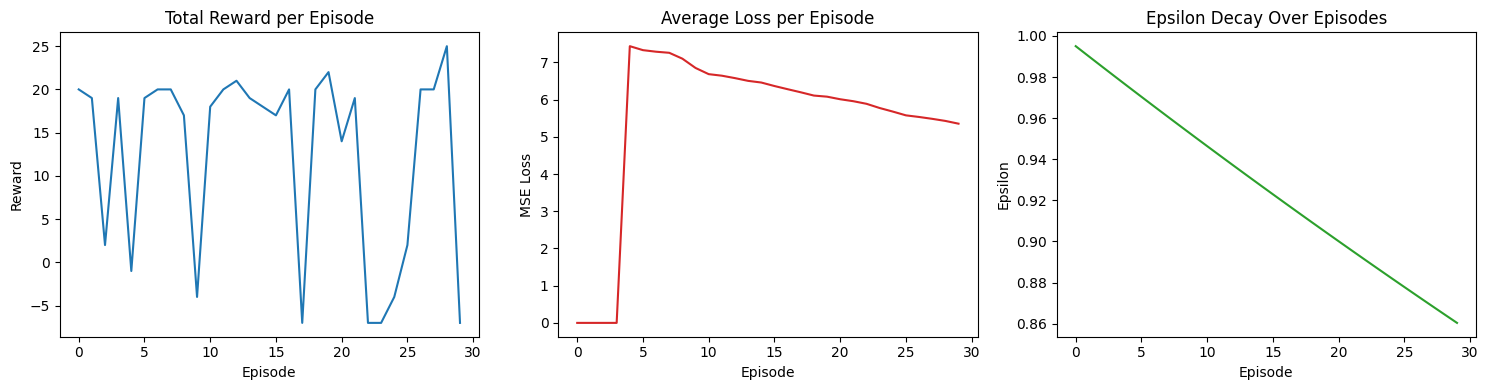

In [11]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(reward_log, color='tab:blue')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 3, 2)
plt.plot(loss_log, color='tab:red')
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("MSE Loss")

plt.subplot(1, 3, 3)
plt.plot(epsilon_log, color='tab:green')
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.tight_layout()
plt.show()

In [12]:
# plt.figure(figsize=(14,4))
# plt.subplot(1,3,1)
# plt.plot(reward_log); plt.title("Total Reward per Episode"); plt.xlabel("Episode"); plt.ylabel("Reward")

# plt.subplot(1,3,2)
# plt.plot(loss_log); plt.title("Batch Loss"); plt.xlabel("Batch"); plt.ylabel("Loss")

# plt.subplot(1,3,3)
# plt.plot(epsilon_log); plt.title("Epsilon Decay"); plt.xlabel("Episode"); plt.ylabel("Epsilon")
# plt.tight_layout(); plt.show()

In [13]:
def visualize_episode_timeline(env):
    plt.figure(figsize=(10, 3))
    events = [env.campaign_to_id[e] for e in env.event_history]
    responses = env.response_history
    conversions = env.conversion_history
    steps = np.arange(len(events))

    plt.plot(steps, events, marker='o', label='Event ID')
    plt.scatter(steps, np.array(responses)*max(events), c='g', label='Responded (1)', marker='x', s=80)
    plt.scatter(steps, np.array(conversions)*max(events), c='r', label='Converted (1)', marker='*', s=120)
    plt.title("Customer Interaction Timeline")
    plt.xlabel("Step")
    plt.ylabel("Campaign (encoded)")
    plt.legend()
    plt.show()

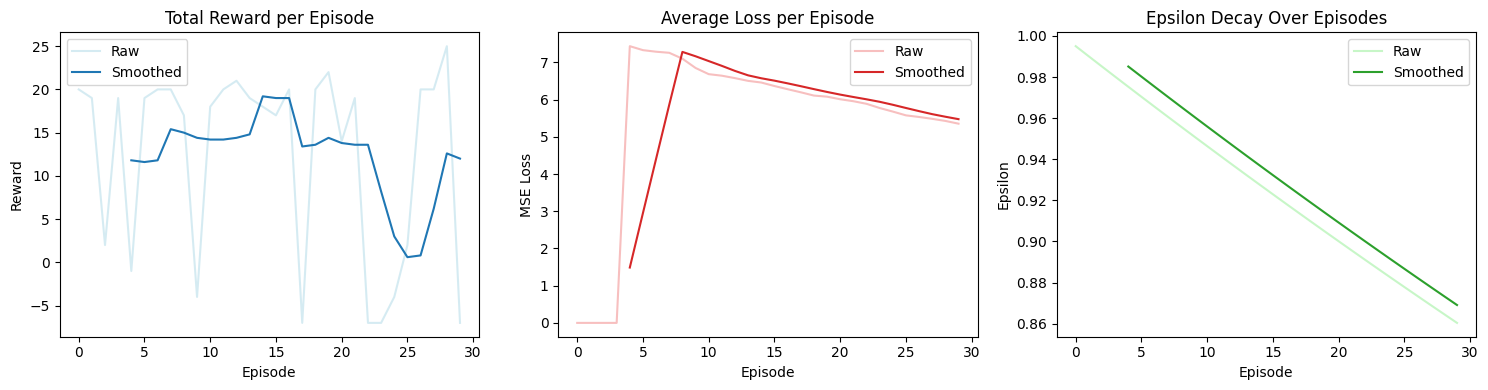

In [16]:
def moving_average(data, window_size=5):
    """Compute simple moving average."""
    if len(data) < window_size:
        return np.array(data)
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Choose smoothing window (e.g., 5 episodes)
window = 5

smoothed_reward = moving_average(reward_log, window)
smoothed_loss = moving_average(loss_log, window)
smoothed_epsilon = moving_average(epsilon_log, window)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(reward_log, color='lightblue', alpha=0.5, label='Raw')
plt.plot(np.arange(window-1, len(reward_log)), smoothed_reward, color='tab:blue', label='Smoothed')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(loss_log, color='lightcoral', alpha=0.5, label='Raw')
plt.plot(np.arange(window-1, len(loss_log)), smoothed_loss, color='tab:red', label='Smoothed')
plt.title("Average Loss per Episode")
plt.xlabel("Episode")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epsilon_log, color='lightgreen', alpha=0.5, label='Raw')
plt.plot(np.arange(window-1, len(epsilon_log)), smoothed_epsilon, color='tab:green', label='Smoothed')
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Example new customer profile
new_profile = np.array([[35, 1, 60000, 2, 0]])  # [age, gender_id, salary, location_id, product_id]

# Simulate empty history (new customer)
empty_event_seq = np.zeros((1, max_seq_len), dtype=np.int32)
empty_resp_seq = np.zeros((1, max_seq_len), dtype=np.int32)
empty_conv_seq = np.zeros((1, max_seq_len), dtype=np.int32)

# Predict Q-values for all actions
pred_q = model.predict([empty_event_seq, empty_resp_seq, empty_conv_seq, new_profile], verbose=0)
best_action = np.argmax(pred_q[0])
all_q = pred_q[0]

print("🧠 Q-values:", all_q)
print("✅ Recommended next action:", campaigns[best_action])

🧠 Q-values: [51956.082 54750.08  43687.938 37266.484]
✅ Recommended next action: SMS Offer


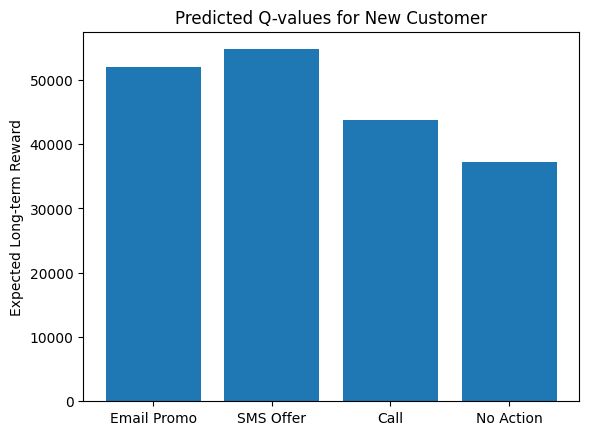

In [15]:
plt.bar(campaigns, all_q)
plt.title("Predicted Q-values for New Customer")
plt.ylabel("Expected Long-term Reward")
plt.show()